## Dependencies

In [49]:
import os
import argparse
import numpy as np
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from rosbags.rosbag1 import Writer
from rosbags.typesys import Stores, get_typestore
from rosbags.typesys.stores.ros1_noetic import std_msgs__msg__Header as Header
from rosbags.typesys.stores.empty import builtin_interfaces__msg__Time as Time

from generator import GenerateRosbag
from transformations import *

In [50]:
def rotateZ(matrix, degrees):
    theta = np.radians(degrees)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation_matrix_z = np.array([
        [cos_theta, -sin_theta, 0, 0],
        [sin_theta, cos_theta, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return np.dot(rotation_matrix_z, matrix)

## Read data

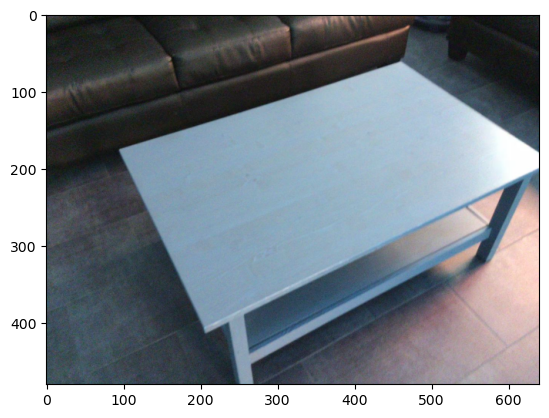

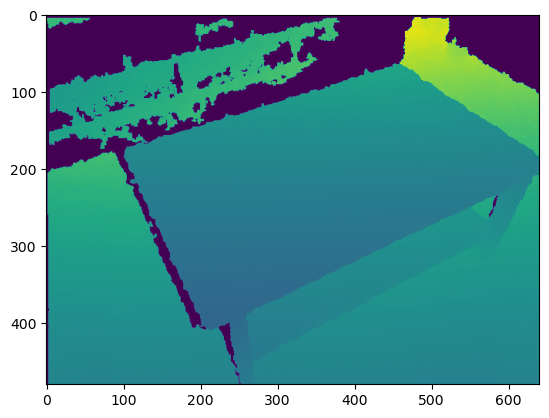

[[ 3.74939946e-33  6.12323400e-17  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  6.12323400e-17  0.00000000e+00  0.00000000e+00]
 [-6.12323400e-17 -1.00000000e+00  6.12323400e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-0.859655  0.347273 -0.374693  3.145171]
 [ 0.510745  0.600786 -0.614977  3.63531 ]
 [ 0.011546 -0.720041 -0.693836  1.440385]
 [ 0.        0.        0.        1.      ]]
[[ 0.374693 -0.859655 -0.347273  3.145171]
 [ 0.614977  0.510745 -0.600786  3.63531 ]
 [ 0.693836  0.011546  0.720041  1.440385]
 [ 0.        0.        0.        1.      ]]
[3.519864 4.250287 2.134221]


In [51]:
# PLACE YOUR DATASET PATH HERE
dataset_path = r"/home/ubuntu/ros2_ws/bag/ScanNet/raw_data/scene0053_00/"

# Data info
n_data = len(os.listdir(dataset_path + "color/"))

# Depth, RGB, segmentation_img, colors.txt (wall class code), extrinsic.txt (poses), intrinsic.txt (poses), camera_number
with open(dataset_path + "intrinsic/intrinsic_depth.txt", 'r') as file:
    data = file.read()
matrix_list = [list(map(float, row.split())) for row in data.strip().split('\n')]
matrix_array = np.array(matrix_list)
intrinsics = [matrix_array[0, 0], matrix_array[1, 1], matrix_array[0, 2], matrix_array[1, 2]]

n = 1
img_rgb = cv2.imread(dataset_path + "color/" + str(n) + ".jpg", -1)
img_depth = cv2.imread(dataset_path + "depth/" + str(n) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.
img_rgb = cv2.resize(img_rgb, (img_depth.shape[1], img_depth.shape[0]), interpolation=cv2.INTER_AREA)
with open(dataset_path + "pose/" + str(n) + ".txt", 'r') as file:
    data = file.read()
    matrix_list = [list(map(float, row.split())) for row in data.strip().split('\n')]

pose =  rotateZ(np.array(matrix_list), 0)

xyz = np.array([0,1,0])
xyz_global = pose[:3,:3] @ xyz + pose[:3,3]

plt.imshow(img_rgb)
plt.show()
plt.imshow(img_depth)
plt.show()

origin, xaxis, yaxis, zaxis = (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)
Rx = rotation_matrix(np.radians(-90), xaxis)
Ry = rotation_matrix(np.radians(90), yaxis)
Rz = rotation_matrix(np.radians(-90), zaxis)

pose_new = pose @ Rz @ Ry
print(Ry@Rz)
print(pose)
print(pose_new)
print(pose_new[:3,:3] @ np.array([1,0,0]) + pose_new[:3,3])



## Create rosbag

bag_path:  ../to_ros/ROS1_bags/scene0053_00.bag


  0%|          | 2/545 [00:00<01:40,  5.42it/s]

100%|██████████| 545/545 [01:38<00:00,  5.53it/s]


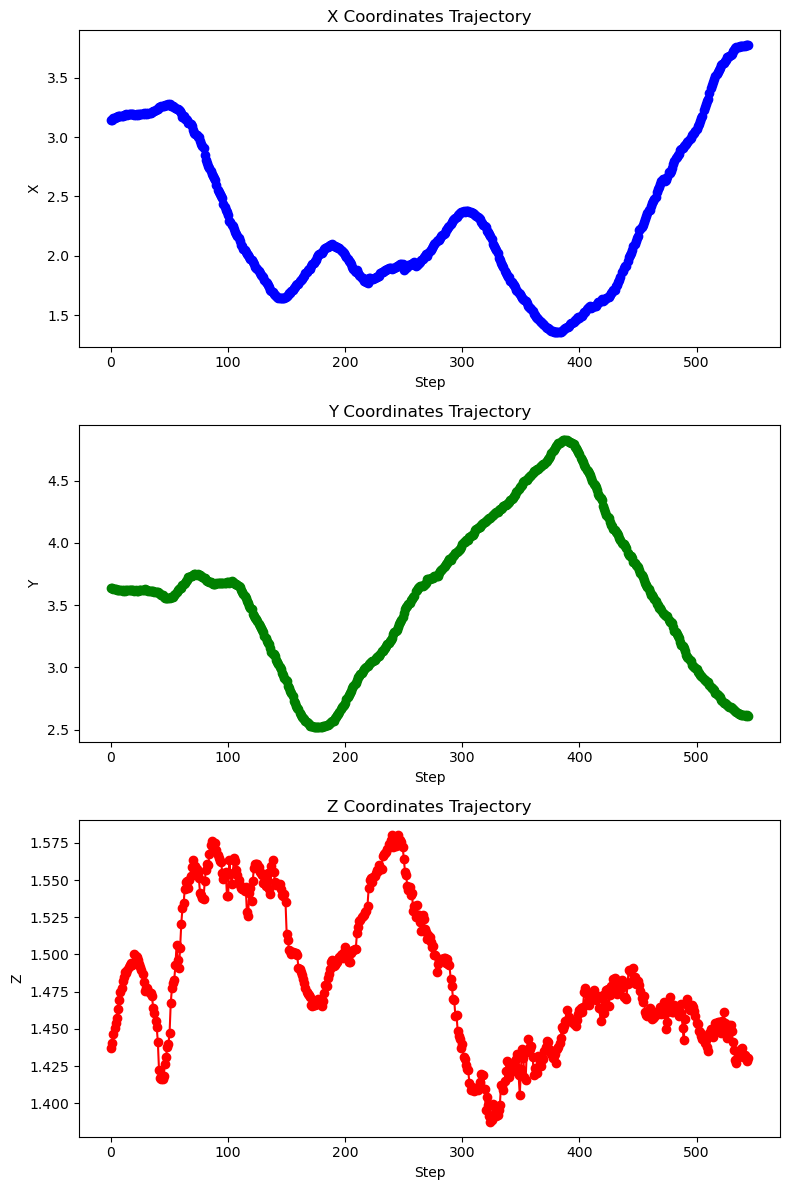

In [52]:
typestore = get_typestore(Stores.ROS1_NOETIC)
rb = GenerateRosbag()
bag_path = "../to_ros/ROS1_bags/" + dataset_path.split("/")[-2] + ".bag"

print("bag_path: ", bag_path)

pose_1 = []
pose_2 = []
pose_3 = []

origin, xaxis, yaxis, zaxis = (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)
Rx = rotation_matrix(np.radians(-90), xaxis)
Ry = rotation_matrix(np.radians(90), yaxis)
Rz = rotation_matrix(np.radians(-90), zaxis)

with Writer(bag_path) as writer:
    camera_rgb = writer.add_connection("camera/rgb", "sensor_msgs/msg/Image", typestore=typestore)
    camera_depth= writer.add_connection("camera/depth", "sensor_msgs/msg/Image", typestore=typestore)
    camera_info = writer.add_connection("camera/camera_info", "sensor_msgs/msg/CameraInfo", typestore=typestore)
    amcl_pose = writer.add_connection("amcl_pose", "geometry_msgs/msg/PoseWithCovarianceStamped", typestore=typestore)

    for i in tqdm(range(n_data)):
        
        header = Header(seq=i, stamp=Time(sec=i,nanosec=0), frame_id="camera")

        img_rgb = cv2.imread(dataset_path + "/color/" + str(i) + ".jpg", -1)
        img_depth = cv2.imread(dataset_path + "/depth/" + str(i) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.
        img_rgb = cv2.resize(img_rgb, (img_depth.shape[1], img_depth.shape[0]), interpolation=cv2.INTER_AREA)
        
        with open(dataset_path + "/pose/" + str(i) + ".txt", 'r') as file:
            data = file.read()
            matrix_list = [list(map(float, row.split())) for row in data.strip().split('\n')]
        pose = np.array(matrix_list) @ np.linalg.inv(Ry @ Rz)

        pose_quat = quaternion_from_matrix(pose)
        pose_t = pose[:3,3].reshape(-1)
        pose = [*pose_quat] + [*pose_t]

        pose_1.append(pose_t[0])
        pose_2.append(pose_t[1])
        pose_3.append(pose_t[2])

        rgb_msg = rb.create_image_msg(img_rgb, deepcopy(header))
        rgb_msg = typestore.serialize_ros1(rgb_msg,"sensor_msgs/msg/Image")

        depth_msg = rb.create_image_msg(img_depth, deepcopy(header))
        depth_msg = typestore.serialize_ros1(depth_msg,"sensor_msgs/msg/Image")

        cam_info_msg = rb.create_camera_info_msg(img_rgb, intrinsics, deepcopy(header))
        cam_info_msg = typestore.serialize_ros1(cam_info_msg,"sensor_msgs/msg/CameraInfo")

        pose_msg = rb.create_pose_msg(pose, deepcopy(header))
        pose_msg = typestore.serialize_ros1(pose_msg,"geometry_msgs/msg/PoseWithCovarianceStamped")

        timestamp = int(i * 1e9)
        writer.write(camera_rgb, timestamp, data = rgb_msg)
        writer.write(camera_depth, timestamp, data = depth_msg)
        writer.write(camera_info, timestamp, data = cam_info_msg)
        writer.write(amcl_pose, i, data = pose_msg)


fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot x coordinates trajectory
axs[0].plot(pose_1, marker='o', linestyle='-', color='b')
axs[0].set_title('X Coordinates Trajectory')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('X')

# Plot y coordinates trajectory
axs[1].plot(pose_2, marker='o', linestyle='-', color='g')
axs[1].set_title('Y Coordinates Trajectory')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Y')

# Plot z coordinates trajectory
axs[2].plot(pose_3, marker='o', linestyle='-', color='r')
axs[2].set_title('Z Coordinates Trajectory')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()